# 1. Automated Data Profiling In Python

**Author : Anandakumar Varatharajah**
<br>
***http://www.analyticsinsights.ninja***

Version   : 0.14  
Date      : 25 May 2019  
License   : MIT License

The main objective of this notebook is **only** to understand raw data profile. i.e. data type, min & max values, ranges, unique values, etc.  
In consequent notebooks we will explore further on how to make decisions to make the data tidy and perform the data transformations based on the understanding of the data profile.
<br>
The code is largely kept generic so that it could be used with any shape of data. 

# The Game Changer - Data Profile Dataframe (DPD)

The game changer for exploratory data analysis is the final ***Data Profile Dataframe*** that is generated which combines ***all*** the information required to inform data cleaning, tidy data and optimisations (memory and processing) decisions.  
Instead of using various Pandas commands at different instances and going back and forth to cross refer information, Data Profile Dataframe brings all information into a single dataframe. This will be very useful when reviewing the data profile with the business subject matter or other team members as all information related to data profile is in a single easy to understand format.

![image.png](DPD_image_small.png)

Understanding the data is **the critical step** in preparing the data to be used for analytics. As many experts will point out the data preparation and transforming the data into a tidy format takes about 80% of the effort in any data analytics or data analysis project.<br>
***Understanding the data requires good understanding of the domain and/or access to a subject matter expert (SME) to help make decisions about data quality and data usage:***
* What are the columns and what do they mean?
* How to interpret each columns and possible values of a column?
* Should the columns be renamed (and cleaned e.g. trim)?
* Are there columns that may have similar information that could be dropped in favour of one master column?
* Can columns with no values (or all empty) be dropped?
* Can columns which have more than certain threshold of blank values be dropped?
* How can the missing values be filled and can it be filled meaningfully?
* Can rows that have missing values for certain columns or combination of columns be dropped? i.e. the row is meaningless wihtout those values.
* Can the numeric data type columns be converted / down casted to optimise memory usage based on the data values?
    - or will there be outliers possibly in future data sets that we cannot do this?
    - can the min and max values be used to determine the lowest possible data type?
* Can some string/object columns be converted to Category types?
    - based on count of unique values
* Can any columns be discarded that may not be required for analytics?

# Environment setup

It is recommended best practice to document the execution environment.  
e.g. When the initial version of this notebook was developed in Azure Notebooks (Jupyter) the environment was documented in the code. When the notebook was exported to local PC JupyterLab and then imported back into Azure Notebook, the Kernal changed to an older version and some code did not work. Having the initital versions documented in comments saved a lot of effort in trying to understand what went wrong.


In [1]:
# Get the date of execution
import datetime
date_generated = datetime.datetime.now()


In [2]:
from platform import python_version 
# use python_version() to get the version. This is used in the final DPD HTML
# 3.6.6 in Azure Notebooks in April 2019


In [3]:
import pandas as pd
# use pd.__version__ to get the pandas version. This is used in the final DPD HTML
# Pandas version   0.22.0 in Azure Notebooks in April 2019

# set maximum number of columns to display in notebook
pd.set_option('display.max_columns', 250)

# To check whether a column is numeric type
from pandas.api.types import is_numeric_dtype

# To check whether a column is object/string type
from pandas.api.types import is_string_dtype


In [4]:
import numpy as np


In [5]:
# Import HTML to display the final DPD HTML table or any HTML code
from IPython.display import HTML


In [6]:
# Import the graph packages
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

import seaborn as sns
# Seabotn version   0.9.0 in Azure Notebooks in April 2019
# use sns.__version__ to get the pandas version. This is used in the final DPD HTML

In [7]:
# Create the directories for images and the DPD HTML file
# if they do not already exists 
import os

# Create directory
dirName = 'data_profile_df_HTML'

try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  data_profile_df_HTML  already exists


# Raw data file exploration

The raw data file used in this notebook has been derived from the Sales Products csv file from IBM Analytics Community and has been modified to include untidy data for the purposes of this data exploration work.  
The raw data should be in a format that can be laoded into pandas. i.e. if there are any rows need to be skipped,  column headers mapped, etc. should be handle in the pandas.read code block.

In [8]:
# Data file to be loaded
raw_data_file = "data/credit_train.csv"


In [9]:
# Use Pandas to load the data file into a dataframe
try:
    df = pd.read_csv(raw_data_file, thousands=',', float_precision=2)
except:
    print("Error: Data file not found!")
#     import sys
#     sys.exit("ERROR: File not found!")


**Note:** If the raw data is a big data file of several GB's in size it may not be possible to load the the whole file into memory. One possibility is using 'pandas pyspark'.<br>
Other options to load data incrementally and optimise the data by converting data types will be demonstrated in a seperate notebook.

In [10]:
# Sample raw data rows from dataset
df.sample(5).round(2)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
69323,08d8e231-5254-48d7-b81d-056633c8210c,b8207dcc-26c9-45f2-bb24-21e49668b891,Fully Paid,116314.0,Short Term,749.0,1860290.0,3 years,Rent,other,49297.78,16.4,NaN,18.0,0.0,697528.0,1120218.0,0.0,0.0
63417,6d1dbe29-cced-441d-b75a-84f03f06adc9,e39981a4-f347-4a62-9657-85c0f0fb837e,Fully Paid,109626.0,Short Term,689.0,1382155.0,10+ years,Own Home,Home Improvements,230.47,17.7,54.0,2.0,0.0,7600.0,15356.0,0.0,0.0
20847,892ad123-1759-4765-b955-554b7f1da188,c46ccbe3-8ef2-4958-b98f-34e480e3eb71,Fully Paid,224048.0,Short Term,746.0,928777.0,2 years,Home Mortgage,Debt Consolidation,7043.30,9.0,NaN,9.0,0.0,227639.0,546876.0,0.0,0.0
41890,04a29208-7ed4-4e53-a5ec-910ff7b334c5,5353db46-d6a9-44d8-9f58-6fb716b2265f,Fully Paid,218790.0,Short Term,NaN,NaN,10+ years,Rent,Debt Consolidation,14196.80,25.8,79.0,11.0,0.0,266798.0,387134.0,0.0,0.0
64400,543e404c-6ccd-4ffe-bab6-a2c6d73397e3,499b9ef4-0d24-4d6c-9cdc-2b045f27cfda,Fully Paid,489698.0,Short Term,733.0,1227229.0,10+ years,Home Mortgage,Debt Consolidation,6003.24,25.0,NaN,6.0,0.0,89965.0,227436.0,0.0,0.0


# Memory Usage Analysis

In [11]:
# Check whether the file is obatined from url.
# If from url, then skip file size in disk check

if "http" in raw_data_file:
    file_size = float('nan')
else:
    # Calculating file size (in MB) on disk
    import os

    file_size = (os.stat(raw_data_file).st_size / 1024 **2)
    #This is used in the DPD HTML


In [12]:
# Calculate dataset size in memory (MB)
df_mem = df.memory_usage(deep=True).sum() / 1024**2
#This is used in the DPD HTML


In [13]:
# Calclulate dataset size increase in memory (MB)
sz_increase = ((df_mem - file_size) / file_size)
#This is used in the DPD HTML

In [14]:
# Plot the memory usage 
# Create a dictionary from the variables and convert to Pandas DataFrame
# Use DataFrame's ploting capabilities
raw_data_dict = {"File on disk":file_size, "Dataset in memroy": df_mem}
raw_data_plot = pd.DataFrame.from_dict(raw_data_dict, orient='index').reset_index()

# Pandas DataFrame plot
raw_data_plot.plot(kind='bar',\
                   x="index" ,\
                   y=0, \
                   legend=False, \
                   title='Data size increase from disk to memory')
# plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.xticks(rotation=0)

# Save the figure
plt.savefig('fig_df_tot_memory.png', dpi=50)
plt.close('all')


In [15]:
# Get memory used by each column in the raw data dataset in MB
# This will be later merged with the DPD
mem_used_dtypes = pd.DataFrame(df.memory_usage(deep=True) / 1024**2)

# Rename column
mem_used_dtypes.rename(columns={ 0:'memory'}, inplace=True)

# Drop index memory usage since this is not required when merging with Data Quality Dataframe
mem_used_dtypes.drop('Index', axis=0, inplace=True) 


# Constructing The Data Profile Dataframe (DPD) - The Game Changer 

In [16]:
# Number of rows of the DPD will be the count of columns in the raw date dataframe
# Since it there will be one row for each column
no_of_rows = len(df.columns)


# Constructing the data_qlt_df dataframe and pre-assigning and columns
# Pre-assigning the number of rows the dataframe would have is memory and processing efficient
# This is a better approach than continuous append or concat operation to dataframe

data_qlt_df = pd.DataFrame(index=np.arange(0, no_of_rows), \
                            columns=('column_name', 'col_data_type', 'col_memory','non_null_values', \
                                     'unique_values_count', 'column_dtype')
                          )


# Add rows to the data_qlt_df dataframe
for ind, cols in enumerate(df.columns):
    # Count of unique values in the column
    col_unique_count = df[cols].nunique()
    
    data_qlt_df.loc[ind] = [cols, \
                            df[cols].dtype, \
                            mem_used_dtypes['memory'][ind], \
                            df[cols].count(), \
                            col_unique_count, \
                            cols + '~'+ str(df[cols].dtype)
                            ]


In [17]:
# Use describe() to get column stats of raw dataframe
# This will be merged with the DPD
raw_num_df = df.describe().T.round(2)


In [18]:
#----- Key Step ---------------
# Merging the df.describe() output with rest of the info to create a single Data Profile Dataframe
data_qlt_df = pd.merge(data_qlt_df, raw_num_df, how='left', left_on='column_name', right_index=True)


In [19]:
# Calculate percentage of non-null values over total number of values
data_qlt_df['%_of_non_nulls'] = (data_qlt_df['non_null_values']/df.shape[0])*100

# Calculate null values for the column
data_qlt_df['null_values'] = df.shape[0] - data_qlt_df['non_null_values']

# Calculate percentage of null values over total number of values
data_qlt_df['%_of_nulls'] = 100 - data_qlt_df['%_of_non_nulls']

# Calculate percentage of each column memory usage compared to total memory used by raw data datframe
data_qlt_df['%_of_total_memory'] = data_qlt_df['col_memory'] / data_qlt_df['col_memory'].sum() * 100

# Calculate the total memory used by a given group of data type
# See Notes section at the bottom of this notebook for advatages of using 'transform' function with group_by
data_qlt_df["dtype_total"] = data_qlt_df.groupby('col_data_type')["col_memory"].transform('sum')

# Calculate the percentage memory used by each column data type compared to the total memory used by the group of data type
# the above can be merged to one calculation if we do not need the total as separate column
#data_qlt_df["%_of_dtype_mem2"] = data_qlt_df["Dtype Memory"] / (data_qlt_df.groupby('Data Type')["Dtype Memory"].transform('sum')) * 100
data_qlt_df["%_of_dtype_mem"] = data_qlt_df["col_memory"] / data_qlt_df["dtype_total"] * 100

# Calculate the percentage memory used by each group of data type of the total memory used by dataset
data_qlt_df["dtype_%_total_mem"] = data_qlt_df["dtype_total"] / df_mem * 100

# Calculate the count of each data type
data_qlt_df["dtype_count"] = data_qlt_df.groupby('col_data_type')["col_data_type"].transform('count')

# Calculate the total count of column values
data_qlt_df["count"] = data_qlt_df['null_values'] + data_qlt_df['non_null_values']

In [20]:
# Reorder the Data Profile Dataframe columns
data_qlt_df = data_qlt_df[
                            ['column_name', 'col_data_type', 'col_memory', '%_of_dtype_mem', '%_of_total_memory',\
                             'dtype_count', 'dtype_total', 'dtype_%_total_mem', 'non_null_values', '%_of_non_nulls',\
                             'null_values', '%_of_nulls', 'unique_values_count', 'count', 'mean', 'std', 'min', '25%',\
                             '50%', '75%', 'max']
                         ]


**The above data quality data frame summarises all information required for making data quality decisions.**  
Though there are info() and describe() methods to do these, having all the relvant information in one dataframe makes the data quality exploration much easier. This dataframe can be used for summarising information and for plotting to ehnace the ease of Data Understanding effort.

# Plot Memory Usage Analysis

In [62]:
# Plot count of column data types and memory used by each datatype
plt_dtype = data_qlt_df.groupby('col_data_type')['dtype_count', 'dtype_total', 'dtype_%_total_mem'].last().sort_values(by='dtype_count')

fig1, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.20)

plt_dtype.plot(kind='bar', y='dtype_count',  use_index=True, legend=False, ax=ax, title='Count of columns by data type')

plt_dtype.plot(kind='bar', y='dtype_total',  use_index=True, legend=False, ax=ax2, title='Memory used by data type')

fig1.savefig("fig_cols_memory.png", dpi=50)
plt.close('all')

In [66]:
# Memory used by columns of raw data dataframe
fig2, ax = plt.subplots(ncols=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.30)

# Memory used by object data type
(data_qlt_df[data_qlt_df['col_data_type'] == 'object']
 .sort_values(by='col_memory', ascending=False)
 .plot(kind="bar", 
       x="column_name", 
       y="col_memory", 
       title="Memory (MB) usage by columns of object data type",
      legend=False, ax=ax)
)
plt.xticks(rotation=35)
fig2.savefig("fig_object_cols_memory.png", dpi=50)
plt.close('all')

# Memory used by non-object data type
fig2, ax1 = plt.subplots(ncols=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.30)

(data_qlt_df[data_qlt_df['col_data_type'] != 'object']
 .sort_values(by='col_memory', ascending=False)
 .plot(kind="bar", 
       x="column_name", 
       y="col_memory", 
       title="Memory (MB) usage by columns of non-object data type",
      legend=False, ax=ax1)
)
plt.xticks(rotation=35)

fig2.savefig("fig_non_object_cols_memory.png", dpi=50)
plt.close('all')


# Generate data profile graphs for 'numerical' columns

In [23]:
import numpy as np
from matplotlib.patches import Rectangle

# Get the list of numeric columns from raw dataframe
# need this: from pandas.api.types import is_numeric_dtype
# get numeric columns which are not empty
num_cols = [cols for cols in df.columns if is_numeric_dtype(df[cols]) and len(df[cols].dropna())>0]

iter_len = len(num_cols)

# For each numeric column in the list
for x, col_name in enumerate(num_cols):
    print(x+1, " of ", iter_len, " completed   ",  col_name)
    
    # Create a copy of the column values without nulls or NA
    no_null_col = df[col_name].dropna()
    
    
    # Calculate the 95 percentile of the values
    q25 = np.percentile(no_null_col, 25)
    q75 = np.percentile(no_null_col, 75)    
    q95 = np.percentile(no_null_col, 95)
    
    # Plot the graphs
    fig3 = plt.figure(figsize=(20,15))
    fig3.suptitle("Profile of column  " + col_name, fontsize=25)  #Title for the whole figure
    plt.subplots_adjust(wspace=0.4, hspace=0.35)

    ax1 = fig3.add_subplot(2,3,1)
    ax1.set_title("Box plot for all the values", fontsize=20)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=35)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)
    ax1.boxplot(no_null_col)

    ax1 = fig3.add_subplot(2,3,2)
    ax1.set_title("Distribution of all values", fontsize=20)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=35, fontsize=15)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)
    ax1.hist(no_null_col)

    ax1 = fig3.add_subplot(2,3,3)
    ax1.set_title("Boxplot for quartiles (all values)", fontsize=20)
    if len(no_null_col.value_counts()) >= 4:
        df[u'quartiles'] = pd.qcut(
                        df[col_name],
                        4, duplicates='drop')
        df.boxplot(column= col_name, by=u'quartiles', ax = ax1)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=35, fontsize=15)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)

    ax1 = fig3.add_subplot(2,3,4)
    ax1.set_title("Box plot without outliers", fontsize=20)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=35, fontsize=15)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)
    ax1.boxplot(no_null_col, showfliers=False)

    ax1 = fig3.add_subplot(2,3,5)
    ax1.set_title("Violin plot (<95% percentile)", fontsize=20)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=35, fontsize=15)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)
    ax1.violinplot(no_null_col[no_null_col <= q95])

    
    #Histogram with bin ranges, counts and percentile color
    ax1 = fig3.add_subplot(2,3,6)
    ax1.set_title("Histogram (<95% percentile)", fontsize=20)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=35, fontsize=15)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)

    # Take only the data less than 95 percentile
    data = no_null_col[no_null_col <= q95]

    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    '''
    counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
    bins    = numpy.ndarray of bin edge/range values
    patches = a list of Patch objects.
            each Patch object contains a Rectnagle object. 
            e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
    '''
    counts, bins, patches = ax1.hist(data, bins=10, facecolor=perc_50_colour, edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    ax1.set_xticks(bins.round(2))
    plt.xticks(rotation=70, fontsize=15)

    # Change the colors of bars at the edges
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < q25:
            patch.set_facecolor(perc_25_colour)
        elif leftside > q95:
            patch.set_facecolor(perc_95_colour)
        elif leftside > q75:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax1.get_yticks()[1] * 0.25

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.85, 0.99))
    

    fig3.suptitle("Profile of column  " + col_name, fontsize=25)  #Title for the whole figure
    fig_name = 'fig_' + col_name
    fig3.savefig(fig_name, dpi=50)
    plt.close('all')
    
#     plt.show()

df.drop(u'quartiles', axis=1, inplace=True)

1  of  12  completed    Current Loan Amount
2  of  12  completed    Credit Score
3  of  12  completed    Annual Income
4  of  12  completed    Monthly Debt
5  of  12  completed    Years of Credit History
6  of  12  completed    Months since last delinquent
7  of  12  completed    Number of Open Accounts
8  of  12  completed    Number of Credit Problems
9  of  12  completed    Current Credit Balance
10  of  12  completed    Maximum Open Credit
11  of  12  completed    Bankruptcies
12  of  12  completed    Tax Liens


# Generate data profile graphs for 'object' columns

In [53]:
# Get the list of object columns from raw dataframe
# get object columns which are not empty
obj_cols = [cols for cols in df.columns if is_string_dtype(df[cols]) and len(df[cols].dropna())>0]

iter_len = len(obj_cols)


# For each object column in the list
for x, col_name in enumerate(obj_cols):
    print(x+1, " of ", iter_len, " completed   ",  col_name)
    
    # Create a copy of the column values without nulls or NA
    no_null_col = df[col_name].dropna()

    values_freq_threshold = 25
    col_unique_count = df[col_name].nunique()
    
    # If unique values count is below the threshold value then store the details of unique values
    col_unique_vals = df[col_name].value_counts(normalize=True, sort=True)
    
    # Plot the graphs
    fig4 = plt.figure(figsize=(20,7))
    fig4.suptitle("Profile of column  " + col_name, fontsize=25)  #Title for the whole figure
    plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.35)

    ax1 = fig4.add_subplot(1,1,1)
    ax1.set_title("Bar chart for top 25 values", fontsize=20)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=45, fontsize=15)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)
    
    col_unique_vals.head(values_freq_threshold).sort_values(ascending=False).plot.bar()
    plt.xticks(rotation=75)
    for p in ax1.patches:
        ax1.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=15)
    
    fig4.suptitle("Profile of column  " + col_name, fontsize=25)  #Title for the whole figure
    fig_name = 'fig_' + col_name
    fig4.savefig(fig_name, dpi= 50)

    plt.close('all')
#     plt.show()

1  of  7  completed    Loan ID
2  of  7  completed    Customer ID
3  of  7  completed    Loan Status
4  of  7  completed    Term
5  of  7  completed    Years in current job
6  of  7  completed    Home Ownership
7  of  7  completed    Purpose


# Candidate columns for Category type

Analysing how many unique values an 'object' column has will be useful to detrmine which columns are good candidates for *Categorical* data type. In combination with the total memory used by 'object' data type and each 'object' data type column, decisions can be made on converting them Category type.

In [25]:
# Create a df and a column for % of memory by each object column
cardn_df = data_qlt_df[data_qlt_df['col_data_type'] == 'object'][['column_name', 'col_memory', '%_of_dtype_mem', '%_of_total_memory', 'unique_values_count']]

cardn_df = cardn_df.sort_values('unique_values_count')

# Generate the Correlation plot

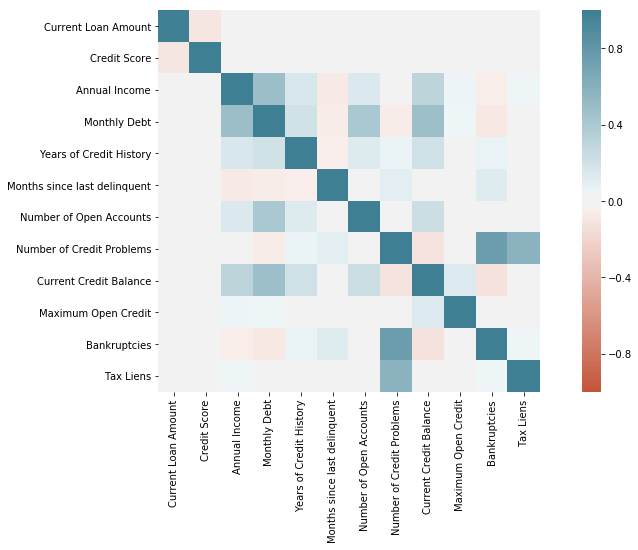

In [56]:
f, ax = plt.subplots(figsize=(15, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.35)
# plt.subplots_adjust(wspace=0.4, hspace=0.5)
# plt.subplots_adjust(bottom=0.25)
# plt.tight_layout()
plt.autoscale()

corr_data = df.corr()
sns.heatmap(corr_data,
            mask=np.zeros_like(corr_data, dtype=np.bool), 
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            vmin=-1, vmax=1,
            square=True, 
            ax=ax)


# plt.xticks(rotation=75)

fig_name = 'fig_cor_plot.png'
f.savefig(fig_name,  dpi=70)
plt.show()
plt.close('all')

# Construct the Data Profile Dataframe HTML table

In [27]:
cardn_html = '\
<html>\
    <body>\
        <table style="table-layout:fixed;" style="text-align:left;" width="1000px" style="border: none;">'

# Main Heading
cardn_html = (cardn_html +\
        '<tr >\
        <td colspan="6" style="text-align:center" bgcolor="black">\
        <font size="6" color="white">Data Profiling of  ' + F'{raw_data_file}' + '</font></strong></td>'
        '</tr>') 

# Environment Info band
cardn_html = (cardn_html +
        '<tr >\
        <td colspan="6" style="text-align:center" bgcolor="#111E6C">\
        <font size="5" color="white">Execution Environment Information</font></strong></td>'
        '</tr>') 

# Environment details
cardn_html = (cardn_html +
        '<tr >' 
        F'<td style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Date Generated : </font><br><font color="#000080">{date_generated.date()}<br></font></strong></td>'\
        F'<td style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Code Version : </font><br><font color="#000080">1.0<br></font></strong></td>'\
        F'<td style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Python Version : </font><br><font color="#000080">{python_version() }</font></strong></td>'\
        F'<td style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Pandas Version : </font><br><font color="#000080">{pd.__version__ }</font></strong></td>'\
        F'<td style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Matplotlib Version : </font><br><font color="#000080"></font></strong></td>'\
        F'<td style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Seaborn Version : </font><br><font color="#000080">Not used</font></strong></td>'\
        '</tr>')

# Summary Info band
cardn_html = (cardn_html +
        '<tr >\
        <td colspan="6" style="text-align:center" bgcolor="#111E6C">\
        <font size="5" color="white">Data Profile Summary Information</font></strong></td>'
        '</tr>')             

# Dataframe shape
cardn_html = (cardn_html +
        '<tr >' 
        F'<td colspan="3" style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Dataframe rows : </font><font color="#000080">{df.shape[0] :,}</font></strong></td>'
        F'<td colspan="3" style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#D37538">Dataframe Columns :</font><font color="#000080"> {df.shape[1] :,}</font></strong></td>'
        '</tr>')


# Disk and Memory size
cardn_html = (cardn_html + \
          F'<tr><td colspan="6" style="text-align:left" bgcolor="#0F52BA"><font size="3" color="white"> \
          <strong>File size on disk vs. Dataframe size in memory</strong></font></td></tr>')

cardn_html = (cardn_html +
        '<tr >\
        <td colspan="3" style="text-align:left" bgcolor="#E3F2FD" >'\
        '<strong>'\
        F'<font color="#D37538">File size in disk : </font><font color="#000080">{file_size :.2f} MB </font><br>'
        F'<font color="#D37538">Dataframe size in memory :</font><font color="#000080"> {df_mem :.2f} MB </font><br>'
        F'<font color="#D37538">File size increase in memory :</font><font color="red">{sz_increase :.2%} </font></strong><br>'
        '</td>')

img_src1 = '<img src="' + 'fig_df_tot_memory.png' + '" >'
cardn_html = (cardn_html + 
        '<td colspan="3" style="text-align:left" bgcolor="#E3F2FD">'\
        + F'{img_src1}' + \
        '</td></tr>'   )


# Dataframe column types and size in memory
cardn_html = (cardn_html + \
          F'<tr><td colspan="6" style="text-align:left" bgcolor="#0F52BA"><font size="3" color="white"> \
          <strong>Dataframe column types and size in memory</strong></font></td></tr>')
cardn_html = (cardn_html +
        '<tr >' 
        F'<td colspan="3" style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#000080">{plt_dtype.reindex().to_html()}</font></strong></td>'
        )

img_src2 = '<img src="' + 'fig_cols_memory.png' + '" >'
cardn_html = (cardn_html + 
        '<td colspan="3" style="text-align:left" bgcolor="#E3F2FD">'\
        + F'{img_src2}' + \
        '</td></tr>'   )
cardn_html = (cardn_html + 
        '<tr>'
        '<td colspan="6" style="text-align:left" bgcolor="#E3F2FD">'\
        + '<font color="black">'  + "If object (string) data type uses more memory one option is to explore whether there are any possible columns with low cardinality that could be converted to Category data type.\
           If int64 or float64 data type uses high memory then it could be explored whether these can be chnaged to low memory data types of similar data type. e.g float64 to float16" + \
        '</font></td></tr>'   )

# Memory used by 'object' data type
cardn_html = (cardn_html + \
          F'<tr><td colspan="6" style="text-align:left" bgcolor="#0F52BA"><font size="3" color="white"> \
          <strong>Memory used by "object" data type</strong></font></td></tr>')
cardn_html = (cardn_html +
        '<tr >' 
        F'<td colspan="6" style="text-align:left" bgcolor="#E3F2FD"><strong>\
        <font color="#000080">{cardn_df.sort_values("unique_values_count").to_html()}</font></strong></td>'
        '</tr>')

img_src3 = '<img src="' + 'fig_object_cols_memory.png' + '" >'
cardn_html = (cardn_html + 
        '<tr>'
        '<td colspan="6" style="text-align:left" bgcolor="#E3F2FD">'\
        + F'{img_src3}' + \
        '</td></tr>'   )
cardn_html = (cardn_html + 
        '<tr>'
        '<td colspan="6" style="text-align:left;" bgcolor="#E3F2FD">'\
        + '<font color="black">' + "Analysing how many unique values an 'object' column has will be useful to detrmine which columns are good candidates for *Categorical* data type.\
           In combination with the total memory used by 'object' data type and each 'object' data type column, decisions can be made on converting them Category type. <br>\
           Object/string data type columns with low cardinality is suitable for Category type.<br>\
           <strong>The threshold of 'low cardinality' depends on the domain of the data and data usage patterns.</strong>" + \
        '</font></td></tr>'   )


# Memory used by 'non-object' data type
cardn_html = (cardn_html + \
          F'<tr><td colspan="6" style="text-align:left" bgcolor="#0F52BA"><font size="3" color="white"> \
          <strong>Memory used by "Non-Object" data type</strong></font></td></tr>')
# cardn_html = (cardn_html +
#         '<tr >' 
#         F'<td colspan="6" style="text-align:left" bgcolor="#E3F2FD"><strong>\
#         <font color="#000080">{cardn_df.sort_values("unique_values_count").to_html()}</font></strong></td>'
#         '</tr>')

img_src3 = '<img src="' + 'fig_non_object_cols_memory.png' + '" >'
cardn_html = (cardn_html + 
        '<tr>'
        '<td colspan="6" style="text-align:left" bgcolor="#E3F2FD">'\
        + F'{img_src3}' + \
        '</td></tr>'   )
cardn_html = (cardn_html + 
        '<tr>'
        '<td colspan="6" style="text-align:left;" bgcolor="#E3F2FD">'\
        + '<font color="black">' + "By analysing the min and max values of the numeric columns decions can be made to downcast the data type to more memory efficient storage types." + \
        '</font></td></tr>'   )


# Correlation plot
cardn_html = (cardn_html + \
          F'<tr><td colspan="6" style="text-align:left" bgcolor="#0F52BA"><font size="3" color="white"> \
          <strong>Data Correlation Plot</strong></font></td></tr>')

img_src3 = '<img src="' + 'fig_cor_plot.png' + '" >'
cardn_html = (cardn_html + 
        '<tr>'
        '<td colspan="6" style="text-align:left" bgcolor="#E3F2FD">'\
        + F'{img_src3}' + \
        '</td></tr>'   )


# Column details band
cardn_html = (cardn_html +
        '<tr >\
        <td colspan="6" style="text-align:center" bgcolor="#111E6C">\
        <font size="5" color="#fff">Data Profile Detail Information</font></strong></td>'
        '</tr>') 

# Iterate over the rows of Data Quality Dataframe to print unique values and normalised frequencies
for ind, row in data_qlt_df.iterrows():

    # Column name
    cardn_html = (cardn_html + \
              F'<tr><td colspan="6" style="text-align:left" bgcolor="#0F52BA"><font size="3" color="white"> \
              <strong>{data_qlt_df["column_name"][ind]}</strong></font></td></tr>')
    
    # Value counts
    cardn_html = (cardn_html +
            '<tr >' 
            F'<td style="text-align:left;" bgcolor="#73C2FB"> <strong>\
            <font color="#D37538">Data Type : </font><br><font color="#000080">{data_qlt_df["col_data_type"][ind]}</font></strong></td>'
            F'<td style="text-align:left" bgcolor="#73C2FB"><strong>\
            <font color="#D37538">Unique Count :</font><br><font color="#000080"> {data_qlt_df["unique_values_count"][ind] :,}</font></strong></td>'
            F'<td style="text-align:left" bgcolor="#73C2FB"><strong>\
            <font color="#D37538">Non-Nulls Count  : </font><br><font color="#000080"> {data_qlt_df["non_null_values"][ind] :,} \
            ({  data_qlt_df["%_of_non_nulls"][ind] :.2f})%</font></strong></td>'
            F'<td style="text-align:left" colspan="2" bgcolor="#73C2FB"><strong>\
            <font color="#D37538">Nulls Values Count  : </font><br><font color="#000080"> {data_qlt_df["null_values"][ind] :,} \
            ({  data_qlt_df["%_of_nulls"][ind] :.2f})%</font></strong></td>'
           F'<td style="text-align:left" bgcolor="#73C2FB"><strong>\
            <font color="#D37538">Total Count  : </font><br><font color="#000080"> {data_qlt_df["count"][ind] :,}</font></strong></td>'
                  '</tr>')

    # Memory details
    cardn_html = (cardn_html +
        '<tr>'
        F'<td style="text-align:left" bgcolor="#64B5F6"><strong>\
        <font color="#D37538">Column Memory : </font><br><font color="#000080"> {data_qlt_df["col_memory"][ind] :,.2} MB</font></strong></td>'
        F'<td style="text-align:left" colspan="2" bgcolor="#64B5F6"><strong>\
        <font color="#D37538">Column Memory as % of Dtype Memory  : </font><br><font color="#000080"> {data_qlt_df["%_of_dtype_mem"][ind] :.2f}% </td>' \
        F'<td style="text-align:left" colspan="3" bgcolor="#64B5F6"><strong>\
        <font color="#D37538">Column Memory as % of Raw Data DF Memory  : </font><br><font color="#000080"> {data_qlt_df["%_of_total_memory"][ind] :,.2f}%</td>'
        '</tr>')
 
    
    # Include max. min etc. only for non-object (numeric) columns
    if data_qlt_df.iloc[ind]['col_data_type'] != 'object':
        # Column statistics
        cardn_html = (cardn_html +
            '<tr>'
            F'<td style="text-align:left" bgcolor="#BBDEFB"><strong>\
            <font color="#D37538">Mean : </font><br><font color="#000080"> {data_qlt_df["mean"][ind] :,.2f}</font></strong></td>'
            F'<td style="text-align:left" bgcolor="#BBDEFB"><strong>\
            <font color="#D37538">Min  : </font><br><font color="#000080"> {data_qlt_df["min"][ind]  :,.2f} </font></strong></td>'
            F'<td style="text-align:left" bgcolor="#BBDEFB"><strong>\
            <font color="#D37538">25%  : </font><br><font color="#000080"> {data_qlt_df["25%"][ind]  :,.2f} </font></strong></td>'
            F'<td style="text-align:left" bgcolor="#BBDEFB"><strong>\
            <font color="#D37538">50%  : </font><br><font color="#000080"> {data_qlt_df["50%"][ind]  :,.2f} </font></strong></td>'
            F'<td style="text-align:left" bgcolor="#BBDEFB"><strong>\
            <font color="#D37538">75%  : </font><br><font color="#000080"> {data_qlt_df["75%"][ind]  :,.2f} </font></strong></td>'
            F'<td style="text-align:left" bgcolor="#BBDEFB"><strong>\
            <font color="#D37538">Max  : </font><br><font color="#000080"> {data_qlt_df["max"][ind] :,.2f} </font></strong></td>'
            '</tr>')
    
    
    img_src = '<img src="' + 'fig_' + data_qlt_df['column_name'][ind] + '.png' + '" width="100%">'
    cardn_html = (cardn_html + 
            '<tr>'
            '<td colspan="6" style="text-align:left" bgcolor="#E3F2FD">'\
            + F'{img_src}' + \
            '</td></tr>'   )

    
    
# Footer
cardn_html = (cardn_html +
        '<tr >\
        <td colspan="6" style="text-align:center" bgcolor="black">\
        <font size="2" color="#fff">Author: Anandakumar Varatharajah  (www.AnalyticsInsights.ninja)</font></strong></td>'
        '</tr>') 

# HTML table close
cardn_html = (cardn_html + '</table></body>')


# Write the HTML file to disk
with open("data_profile_dataframe.html","w+") as f:
    f.write(cardn_html)

# Display the Data Profile Dataframe HTML table
HTML(cardn_html)
# print("HTML generated")